# Prelim

## Single Cell Analysis Environment Setup

Follow the steps below to set up a Conda environment for single-cell analysis:

1. **Create a new conda environment named "singlecell"** with necessary packages. We use the `bioconda` and `conda-forge` channels to find packages that are not available in the default channel:

    ```bash
    conda create --name singlecell -y -c bioconda -c conda-forge scanpy scrublet pyranges leidenalg python-igraph jupyterlab ipykernel fa2 ipywidgets
    ```

2. **Activate the "singlecell" environment**. You'll need to do this each time you start a new terminal session before installing new packages:

    ```bash
    conda activate singlecell
    ```

3. **Install additional Python packages** that are not available through Conda. We use `pip`, the Python package installer:

    ```bash
    pip install --upgrade scanpy palantir
    ```

4. **Register the "singlecell" environment with Jupyter**. This allows you to use the environment in Jupyter notebooks:

    ```bash
    python -m ipykernel install --user --name $CONDA_DEFAULT_ENV --display-name "$CONDA_DEFAULT_ENV"
    ```

That's all! You've now set up your single cell analysis environment. Start a Jupyter notebook server by typing `jupyter-lab` into your terminal and begin your analysis. Remember to select the kernel `singlecell` within Jupyter for your analyses.

This primer will use a dataset provided by 10X: https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_protein_v3?

The raw and processed data will be downloaded to the `data/` folder.
1. [Raw data](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5)
2. [Processed data](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/pbmc_10x_rna_processed.h5ad)

# Imports

In [1]:
import os
import warnings
import urllib.request
import numpy as np
import pandas as pd

In [2]:
import scanpy as sc
import palantir
import phenograph

In [3]:
import matplotlib
import matplotlib.pyplot as plt

In [4]:
# Ensure that plots are displayed inline in the Jupyter notebook
%matplotlib inline

# Set the default figure size to 4x4 inches
matplotlib.rcParams["figure.figsize"] = [4, 4]

# Set the default figure resolution to 100 dots per inch
matplotlib.rcParams["figure.dpi"] = 100

# Set the default colormap to 'Spectral_r'
matplotlib.rcParams["image.cmap"] = "Spectral_r"

# Remove bounding boxes and axis
matplotlib.rcParams['axes.spines.bottom'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.left'] = False
matplotlib.rcParams['axes.spines.right'] = False

# Suppress a specific warning from the 'scanpy' module
warnings.filterwarnings("ignore", category=UserWarning, module="scanpy", lineno=392)

# Utility functions

In [5]:
from joblib import Parallel, delayed
from scipy.sparse import hstack
import gc

def log_transform(ad, ps=0.1):
    """
    Applies a pseudo-count log2 transformation to the data in an AnnData object.
    
    The transformation is defined as log2(x + ps) - log2(ps), where x is the original data
    and ps is the pseudo-count. The purpose of the pseudo-count is to avoid taking the log of zero.
    
    Parameters
    ----------
    ad: AnnData
        The AnnData object containing the data to be transformed.
        
    ps: float, optional
        The pseudo-count to be added to the data before taking the logarithm.
        The default value is 0.1.
        
    Returns
    -------
    None
        The function modifies the AnnData object in-place.
    """
    
    # Check if the data in the Anndata object is a numpy array
    if not isinstance(ad.X.data, np.ndarray):
        raise TypeError("The data in the AnnData object should be a numpy array.")
        
    # Check if the pseudo-count is a positive number
    if ps <= 0:
        raise ValueError("The pseudo-count should be a positive number.")
        
    # Apply the log2 transformation
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

def _dot_herlper_func(x, y):
    return x.dot(y)

def impute_data(dm_res, ad, n_steps=3):
    """
    Function to impute gene expression data based on cell similarity.
    
    Parameters
    ----------
    dm_res: dict
        Dictionary containing diffusion map results.
    ad: AnnData
        Annotated Data with sparse gene expression matrix.
    n_steps: int, optional
        Number of steps for the diffusion process, default is 3.
        
    Returns
    -------
    np.array
        Dense matrix with imputed data.
    """
    
    # Preparing the operator
    T_steps = (dm_res["T"] ** n_steps).astype(np.float32)

    # Define chunks of columns for parallel processing
    chunks = np.append(np.arange(0, ad.X.shape[1], 100), [ad.X.shape[1]])

    # Run the dot product in parallel on chunks
    res = Parallel(n_jobs=-1)(
        delayed(_dot_herlper_func)(T_steps, ad.X[:, chunks[i - 1] : chunks[i]])
        for i in range(1, len(chunks))
    )

    # Stack the results together
    imputed_data = hstack(res).todense()
    
    # Set small values to zero
    imputed_data[imputed_data < 1e-2] = 0
    
    # Clean up
    gc.collect()

    return imputed_data

Cell names and genes can be seen using `ad.obs_names` and `ad.var_names` respectively

# Scanpy

[Scanpy](https://scanpy.readthedocs.io/en/stable/) and [Seurat](https://satijalab.org/seurat/) are leading toolkits for single-cell RNA-seq data preprocessing and analysis. While Scanpy is implemented in Python, Seurat offers similar capabilities within the R programming language, giving researchers the flexibility to choose the toolkit that best aligns with their preferred language and workflow.

In this primer, we will delve into the world of single-cell RNA-seq data analysis using Scanpy, focusing on three key areas:

1. **Understanding the `Anndata` class**: This is the core data container used by Scanpy. It's designed to handle and store large amounts of single-cell RNA-seq data in a structured and efficient manner. 

2. **Quality Control (QC) of a real-world dataset**: We will apply Scanpy's functions to perform QC on a publicly available dataset provided by 10X Genomics. This dataset contains single-cell RNA-seq data from peripheral blood mononuclear cells (PBMCs) obtained from a healthy donor. 

3. **Data analysis**: We will explore clustering techniques, generate UMAPs (Uniform Manifold Approximation and Projection) for visualization, and annotate cell types in our dataset. These steps will allow us to identify patterns and make biological inferences from our single-cell data.

For more extensive tutorials on how to use Scanpy for your single-cell RNA-seq data analysis, check out the official [Scanpy tutorials](https://scanpy.readthedocs.io/en/stable/tutorials.html). These guides provide detailed instructions and examples to help you get the most out of the Scanpy toolkit.

# Anndata

The `AnnData` class serves as a central data container for storing single-cell data in Scanpy. It consists of several components, each serving a distinct purpose:

- **.X**: This is the expression matrix of cells by genes (as opposed to the genes-by-cells representation used in R). This matrix can hold either raw or normalized data.
- **.obs**: This is a Pandas dataframe that contains information about cells. Each row corresponds to a cell, and the number of rows in `.obs` matches the number of rows in `.X`. The columns of this dataframe contain annotations related to cells, such as sample ID, cluster ID, cell type, and so on.
- **.var**: This component is similar to `.obs`, but it contains information about genes instead of cells.
- **.obsm**: This is a dictionary of matrices that store additional data about cells. Each entry in `.obsm` has the same number of rows as `.X` and `.obs`, and may include data like UMAPs or Principal Components.
- **.varm**: This component is similar to `.obsm`, but it pertains to genes rather than cells.
- **.uns**: This is a dictionary of dictionaries used for storing unstructured information. Examples of such information could include color mappings for clusters or cell types.

<img src="https://raw.githubusercontent.com/scverse/anndata/main/docs/_static/img/anndata_schema.svg" width="500" height="600"/>

For more information about the `AnnData` class and its components, you can refer to the [official AnnData documentation](https://anndata.readthedocs.io/en/latest/).

## Load anndata

Lets start with loading a previously computed anndata using the `scanpy.read` function. The data can manually be downloaded [here](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/pbmc_10x_rna_processed.h5ad).

In [6]:
# Load the 10x_pbmc.h5ad object
data_dir = "../data/"
download_url = "https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/pbmc_10x_rna_processed.h5ad"
ad = sc.read(data_dir + "pbmc_10x_rna_processed.h5ad", backup_url=download_url)

In [7]:
# Print out the ad object
ad

AnnData object with n_obs × n_vars = 7462 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'phenograph', 'doublet_score', 'predicted_doublet', 'log_n_counts', 'B_cell_score', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'draw_graph', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'scrublet', 'umap'
    obsm: 'DM_EigenVectors', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

This downloads the features.tsv from [here](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/scrna_features.tsv.gz) to `data/` and adds it to the Anndata to allow matching of gene names to ENSEMBL IDs.

In [8]:
# File URL and local file path
url = "https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/scrna_features.tsv.gz"
features_file = os.path.join(data_dir, "scrna_features.tsv.gz")

# Download the file if it does not exist
if not os.path.isfile(features_file):
    urllib.request.urlretrieve(url, features_file)

# Load data
ad.uns["features"] = pd.read_csv(features_file)

## Anndata exploration

Cell names and genes can be seen using `ad.obs_names` and `ad.var_names` respectively

In [9]:
ad.obs_names

Index(['AAACCCAAGATTGTGA-1', 'AAACCCACATCGGTTA-1', 'AAACCCAGTACCGCGT-1',
       'AAACCCAGTCGTCATA-1', 'AAACCCAGTCTACACA-1', 'AAACCCAGTGCAAGAC-1',
       'AAACCCAGTGCATTTG-1', 'AAACCCATCCGATGTA-1', 'AAACCCATCTCAACGA-1',
       'AAACCCATCTCTCGAC-1',
       ...
       'TTTGTTGAGGCCACCT-1', 'TTTGTTGCACGAAAGC-1', 'TTTGTTGCAGAGGAAA-1',
       'TTTGTTGGTCTCTCAC-1', 'TTTGTTGGTGGCCACT-1', 'TTTGTTGGTTCAAGTC-1',
       'TTTGTTGGTTGCATGT-1', 'TTTGTTGGTTGCGGCT-1', 'TTTGTTGTCGAGTGAG-1',
       'TTTGTTGTCGTTCAGA-1'],
      dtype='object', length=7462)

As you can see each cell name is a nucleotide sequence indicating the cell barcode

In [10]:
ad.var_names

Index(['AL669831.5', 'LINC00115', 'FAM41C', 'NOC2L', 'KLHL17', 'HES4', 'ISG15',
       'C1orf159', 'TNFRSF18', 'TNFRSF4',
       ...
       'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB',
       'AL592183.1', 'AC007325.4', 'AC004556.1'],
      dtype='object', length=11892)

Lets examine the `.obs` entry:

In [11]:
# head function lists the top n rows in the table
# Reiteration - ad.obs is just a dataframe and all pandas functions can be used.
ad.obs.head(n=10)

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,phenograph,doublet_score,predicted_doublet,log_n_counts,B_cell_score,celltype
AAACCCAAGATTGTGA-1,2194,6160.0,523.0,8.490260,2,3,0.062667,False,3.789581,-0.345287,EryPre
AAACCCACATCGGTTA-1,2093,6713.0,415.0,6.182034,4,3,0.054612,False,3.826917,-0.333429,EryPre
AAACCCAGTACCGCGT-1,1518,3637.0,287.0,7.891119,2,2,0.062667,False,3.560743,-0.325019,MonoPre
AAACCCAGTCGTCATA-1,1240,2611.0,156.0,5.974722,3,4,0.026025,False,3.416807,-0.268908,Mono2
AAACCCAGTCTACACA-1,2022,5035.0,477.0,9.473684,2,2,0.023100,False,3.701999,-0.371966,MonoPre
AAACCCAGTGCAAGAC-1,1753,4547.0,249.0,5.476138,2,2,0.072485,False,3.657725,-0.324337,MonoPre
AAACCCAGTGCATTTG-1,2511,7977.0,391.0,4.901592,2,2,0.040888,False,3.901840,-0.370778,MonoPre
AAACCCATCCGATGTA-1,962,2969.0,171.0,5.759515,0,0,0.025262,False,3.472610,-0.203489,Mono
AAACCCATCTCAACGA-1,1292,3334.0,154.0,4.619076,0,0,0.042181,False,3.522966,-0.211252,Mono
AAACCCATCTCTCGAC-1,1300,3852.0,163.0,4.231568,0,0,0.062667,False,3.585686,-0.179933,Mono


## Subsetting anndata

Anndata objects can be subset using cell names, gene names, logical vectors for cells and genes

In [12]:
# Anndata object with cell "AAACCCAAGATTGTGA-1"
ad["AAACCCAAGATTGTGA-1", :]

View of AnnData object with n_obs × n_vars = 1 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'phenograph', 'doublet_score', 'predicted_doublet', 'log_n_counts', 'B_cell_score', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'draw_graph', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'scrublet', 'umap', 'features'
    obsm: 'DM_EigenVectors', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [13]:
# Anndata object of pDC cells
ad[ad.obs["celltype"] == "pDC", :]

View of AnnData object with n_obs × n_vars = 0 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'phenograph', 'doublet_score', 'predicted_doublet', 'log_n_counts', 'B_cell_score', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'draw_graph', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'scrublet', 'umap', 'features'
    obsm: 'DM_EigenVectors', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

# Scanpy - Functionality Overview

[Scanpy](https://scanpy.readthedocs.io/en/stable/) is a scalable toolkit for analyzing single-cell gene expression data. It includes preprocessing, visualization, clustering, trajectory inference, and differential expression testing. The Python-based package is built around an [Anndata](https://anndata.readthedocs.io/en/latest/) object, which allows to manage large amounts of data efficiently.

Scanpy is divided into several modules, each containing a broad category of functions:

- **`sc.pp`**: The preprocessing module contains functions that help to clean and normalize the data before analysis. For instance, `sc.pp.pca()` performs Principal Component Analysis (PCA), a crucial step in reducing the dimensionality of the data.
- **`sc.tl`**: This is the tool module. It provides interfaces for a variety of algorithms and methods used in single-cell analysis. For example, `sc.tl.umap()` applies the UMAP (Uniform Manifold Approximation and Projection) algorithm for dimension reduction, which is useful for data visualization.
- **`sc.pl`**: The plotting module is for visualizing data and results. Functions in this module can create a variety of plots, including scatter plots, violin plots, matrix plots, and many more.
- **`sc.external`**: The external module provides interfaces to tools developed by other labs. These tools are not part of the Scanpy package itself but can be used through it. For example, `sc.external.tl.palantir()` allows for the use of the Palantir algorithm for trajectory detection in single-cell data.

The modular structure of Scanpy ensures a clear workflow, where each step of the analysis can be carried out using functions from the appropriate module. For a more detailed understanding of the functions available in each module, refer to the [official Scanpy documentation](https://scanpy.readthedocs.io/).

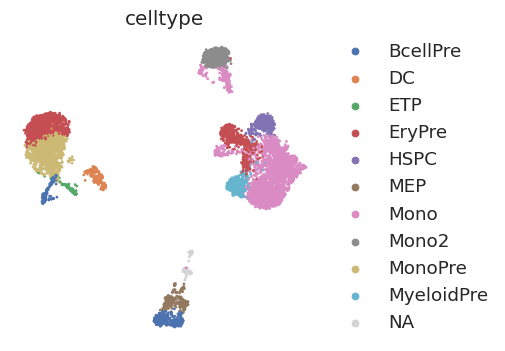

In [14]:
# Plot the umap colored by cell types
sc.pl.umap(ad, color="celltype", frameon=False)

The above function uses the `ad.obms['X_umap']` to plot the umap. If you want to use an alternative visualization, you can use the `sc.pl.scatter` function and specify the representation with the `basis` argument.

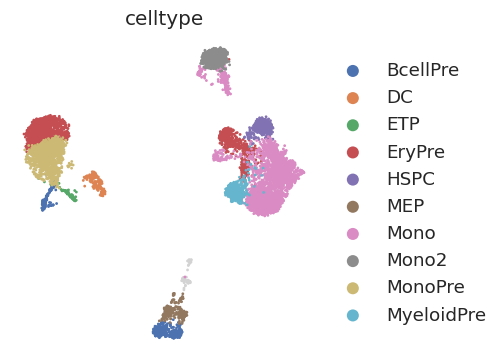

In [15]:
# Plot the umap colored by cell types
sc.pl.scatter(ad, color="celltype", basis="umap", frameon=False)

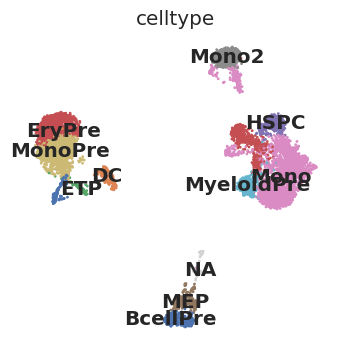

In [16]:
# We can highlight cell-types on the umap itself
sc.pl.umap(ad, color="celltype", legend_loc="on data", frameon=False)

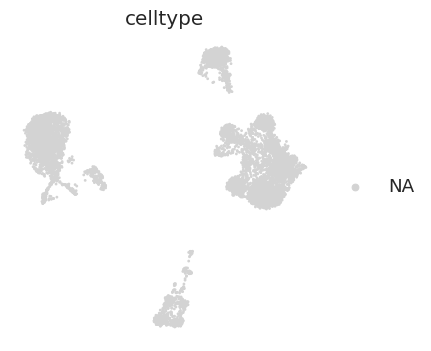

In [17]:
# Or plot specific cell types
sc.pl.umap(ad, color="celltype", groups=["pDC", "B cell precursor"], frameon=False)

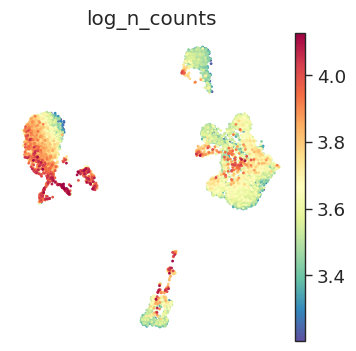

In [18]:
# UMAPs can be colored by continuous values too
sc.pl.umap(ad, color="log_n_counts", frameon=False)

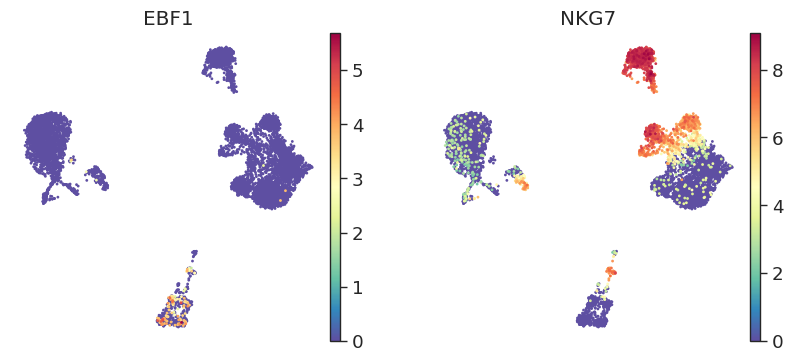

In [19]:
# Or by gene expression values
sc.pl.umap(ad, color=["EBF1", "NKG7"], frameon=False)

Here's an improved version of the preprocessing and QC section, with enhanced descriptions and readability:

# Preprocessing

This section guides you through the preprocessing and quality control (QC) stages, starting from raw data.

## Loading the Data

First, we load the single-cell RNA sequencing data. The data is stored in the Hierarchical Data Format (HDF5), which is commonly used to store large datasets.

In [20]:
data_dir = "../data/"
filename = "pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5"
download_url = "https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/" + filename
file_path = os.path.join(data_dir, filename)

ad = sc.read_10x_h5(file_path, backup_url=download_url)
ad.var_names_make_unique()

/fh/fast/setty_m/user/dotto/mamba/envs/singlecell_test6/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Quality Control

Before diving into the analysis, we perform quality control (QC) to filter out cells and genes that may introduce noise. 

**Note:** A known issue in pandas version 1.3 leads to a `ValueError` with `sc.pp.calculate_qc_metrics`. This issue should be resolved in pandas version 1.4 or later. Please refer to [this link](https://github.com/theislab/scanpy/issues/2008) for more details.

In [21]:
ad.var["mt"] = ad.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    ad,
    qc_vars=["mt"],
    inplace=True,
    percent_top=None,
    log1p=False,
)

### Cell Filtering Based on RNA Content

We examine the distribution of total molecule counts per cell.

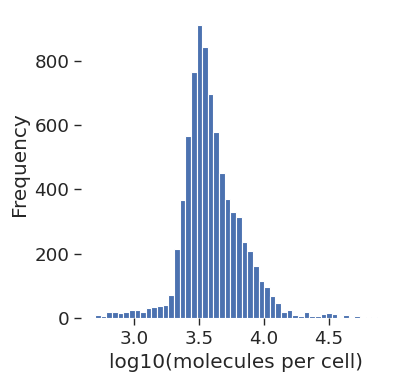

In [22]:
plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs["total_counts"]), bins=50)
ax.set_xlabel("log10(molecules per cell)")
ax.set_ylabel("Frequency")
plt.show()

We then set thresholds on the 3rd and 98th percentiles of the distribution to remove cells with unusually low or high molecule counts.

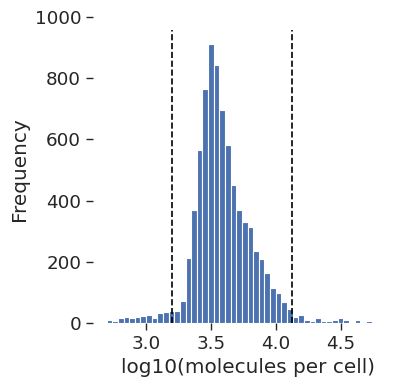

In [23]:
THRESHOLDS = np.log10(np.percentile((ad.obs["total_counts"]), [3, 98]))

plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs["total_counts"]), bins=50)
ax.vlines(THRESHOLDS, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color="black", linestyle="--")
ax.set_xlabel("log10(molecules per cell)")
ax.set_ylabel("Frequency")
plt.show()

We apply the thresholds to filter the cells.

In [24]:
use_cells = ad.obs_names[
    (np.log10(ad.obs["total_counts"]) > THRESHOLDS[0])
    & (np.log10(ad.obs["total_counts"]) < THRESHOLDS[1])
]
ad = ad[use_cells, :]

And visualize the resulting distribution.

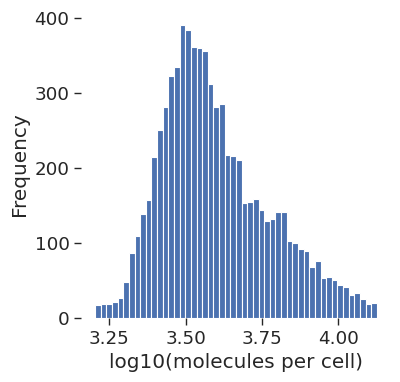

In [25]:
plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs["total_counts"]), bins=50)
ax.set_xlabel("log10(molecules per cell)")
ax.set_ylabel("Frequency")
plt.show()

### Filtering Based on Mitochondrial Content

Cells with high mitochondrial gene content can indicate damaged cells. Therefore, we examine the percentage of mitochondrial genes and filter out cells with unusually high mitochondrial content.

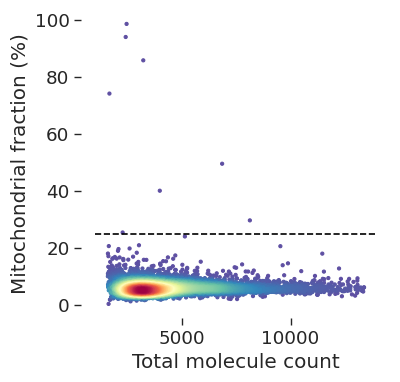

In [26]:
MITO_THRESHOLD = 25
x, y, dens = palantir.plot.density_2d(ad.obs["total_counts"], ad.obs["pct_counts_mt"])

plt.figure()
ax = plt.gca()
ax.scatter(x, y, c=dens, s=5)
ax.hlines(MITO_THRESHOLD, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], colors="black", linestyles="--")
plt.xlabel("Total molecule count")
plt.ylabel("Mitochondrial fraction (%)")
plt.show()

Applying the threshold to filter cells.

In [27]:
ad = ad[ad.obs["pct_counts_mt"] < MITO_THRESHOLD, :]

Let's examine the AnnData object after the QC and filtering steps.

In [28]:
ad

View of AnnData object with n_obs × n_vars = 7462 × 33538
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Now the data is ready for downstream analysis. We have filtered out potentially problematic cells and ensured a uniform distribution of total counts. 

The next step in the analysis pipeline is typically to normalize and scale the data, identify highly variable genes, and perform dimensionality reduction techniques such as PCA, t-SNE, and UMAP for visualization and clustering. 

We will continue with these steps in the following sections.

## Analysis

### Gene Filtering

We begin the analysis by filtering the genes. We keep only those genes that are present in at least 50 cells.

In [29]:
sc.pp.filter_genes(ad, min_cells=50)

/fh/fast/setty_m/user/dotto/mamba/envs/singlecell_test6/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


### Normalization and Log Transformation

Next, we normalize the data per cell to account for differing sequencing depths between cells. We also apply a log transformation to the data to reduce the skewness typically observed in gene expression data.

In [30]:
sc.pp.normalize_total(ad)
log_transform(ad)

### Selecting Highly Variable Genes

Identifying and focusing on highly variable genes is a common strategy to capture the most meaningful sources of cell-to-cell variability. We use the 'cell_ranger' method and select the top 2500 highly variable genes.

In [31]:
sc.pp.highly_variable_genes(ad, flavor="cell_ranger", n_top_genes=2500)

### Principal Component Analysis (PCA)

We perform PCA to reduce dimensionality and identify the principal axes of variation in the data. The number of components is an important parameter - here we choose 50, but typically one would look for a "knee" in the explained variance plot.

In [32]:
sc.pp.pca(ad, use_highly_variable=True, n_comps=50)

### UMAP and Leiden Clustering

To visualize the data in two dimensions, we use the UMAP algorithm. We also perform Leiden clustering to identify groups of similar cells. Both of these require the computation of a nearest-neighbors graph, which we do based on the PCA representation.

In [33]:
sc.pp.neighbors(ad, use_rep="X_pca")
sc.tl.umap(ad)
sc.tl.leiden(ad)

### Diffusion Maps

We compute diffusion maps, which are useful for capturing non-linear structure and identifying trajectories in the data.

In [34]:
dm_res = palantir.utils.run_diffusion_maps(
    pd.DataFrame(ad.obsm["X_pca"], index=ad.obs_names)
)
ad.obsp["DM_Kernel"] = dm_res["kernel"]
ad.obsm["DM_EigenVectors"] = dm_res["EigenVectors"].values
ad.uns["DMEigenValues"] = dm_res["EigenValues"].values

Determing nearest neighbor graph...


### Force Directed Layout

We calculate a force-directed layout based on the diffusion map kernel for further visualization.

In [35]:
sc.tl.draw_graph(ad, adjacency=dm_res["kernel"])

In [36]:
ad

AnnData object with n_obs × n_vars = 7462 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'DMEigenValues', 'draw_graph'
    obsm: 'X_pca', 'X_umap', 'DM_EigenVectors', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'DM_Kernel'

### Phenograph Clustering

We perform another round of clustering, this time using the Phenograph method, which is especially suited for single-cell data.

In [37]:
ad.obs["phenograph"], _, _ = phenograph.cluster(ad.obsm["X_pca"])
ad.obs["phenograph"] = ad.obs["phenograph"].astype(str)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9520399570465088 seconds
Jaccard graph constructed in 1.284646987915039 seconds
Wrote graph to binary file in 0.11975574493408203 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.871895
Louvain completed 21 runs in 2.162242889404297 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 5.377046346664429 seconds


### Imputation

Finally, we perform imputation of the data using the diffusion map we calculated earlier. Imputation can help to fill in gaps in the data where measurements might be missing or unreliable.

In [38]:
ad.layers["MAGIC_imputed_data"] = np.array(impute_data(dm_res, ad))

# Identification of Doublets Using Scrublet

In single-cell RNA-sequencing data, doublets are artifacts arising from two or more cells being erroneously recognized as a single cell, which can potentially skew downstream analyses. 

[Scrublet](https://github.com/AllonKleinLab/scrublet) is a Python package that enables the detection of these doublets. It works by predicting a doublet score for each cell, which is based on the comparison of the cell's transcriptome to those of simulated artificial doublets. Scrublet should ideally be run on a per-sample basis and prior to the data normalization process.

In the following section, we'll incorporate the Scrublet tool to predict doublet scores for each cell. These scores will be stored in our AnnData object, enabling us to filter out doublets in subsequent steps of the analysis.

In [39]:
sc.external.pp.scrublet(ad)

/fh/fast/setty_m/user/dotto/mamba/envs/singlecell_test6/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 59.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


Let's examine the AnnData object after the doublet detection step.

In [40]:
ad

AnnData object with n_obs × n_vars = 7462 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'phenograph', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'DMEigenValues', 'draw_graph', 'scrublet'
    obsm: 'X_pca', 'X_umap', 'DM_EigenVectors', 'X_draw_graph_fa'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data'
    obsp: 'distances', 'connectivities', 'DM_Kernel'

# Visualization of Analysis Results

Visualizing the results of our analysis is a crucial step in understanding the data and verifying the effectiveness of our preprocessing. Here we generate a series of scatter plots using different bases and colorings to represent various aspects of our data.

First, we add a new observation to our AnnData object representing the log-transformed total counts per cell.

In [41]:
ad.obs["log_n_counts"] = np.log10(ad.obs["total_counts"])
%matplotlib inline

Let's start by visualizing the data in UMAP and Force-Directed Layout space, colored by the log-transformed total counts.

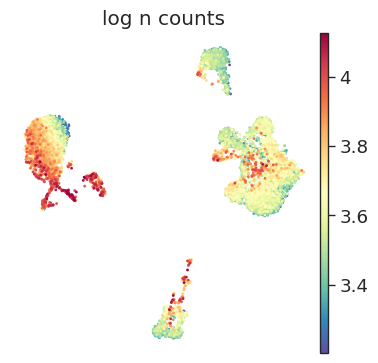

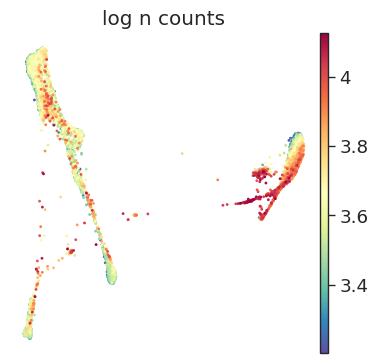

In [42]:
sc.pl.scatter(ad, basis="umap", color="log_n_counts", frameon=False)
sc.pl.scatter(ad, basis="draw_graph_fa", color="log_n_counts", frameon=False)

Next, we'll color the UMAP plot by the Phenograph clustering results.

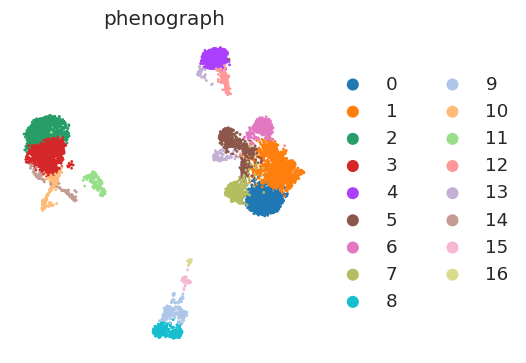

In [43]:
sc.pl.scatter(ad, basis="umap", color=["phenograph"], frameon=False)

Finally, let's visualize the UMAP plot colored by the doublet scores, predicted doublet status, and Phenograph clustering results. This will help us understand how the predicted doublets are distributed across different clusters and whether specific clusters are more prone to doublet formation.

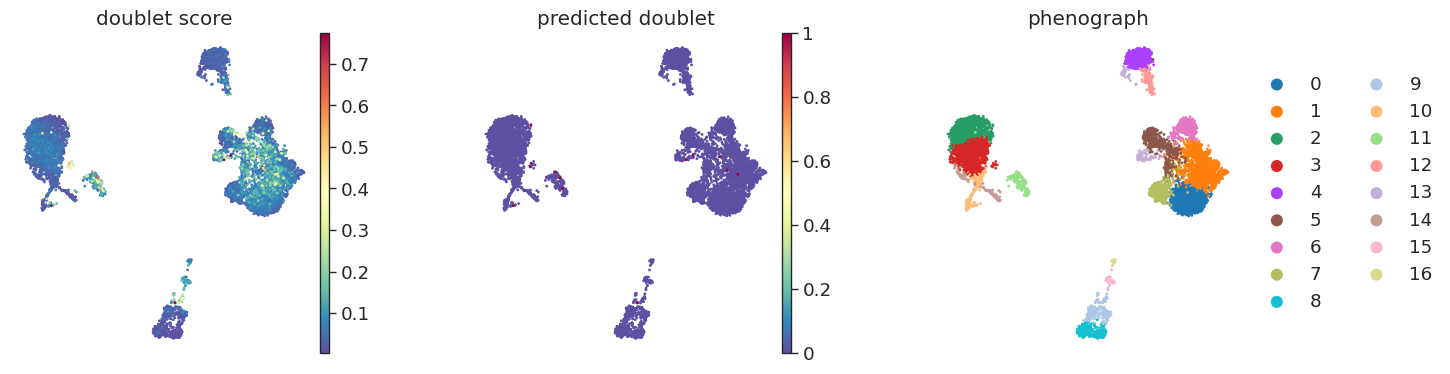

In [44]:
sc.pl.scatter(
    ad,
    basis="umap",
    color=["doublet_score", "predicted_doublet", "phenograph"],
    frameon=False,
)

The scatter plots generated provide a visual representation of our data after preprocessing and clustering. They can be used to identify trends and patterns in the data, assess the quality of the clustering results, and detect potential issues such as high prevalence of doublets in specific clusters.

# Cell Type Annotation

Cell type annotation in single-cell RNA-seq data is crucial for understanding the identity of cells and the biological processes they are involved in. Here, we will use the expression of known marker genes to infer the cell types present in our data.

Let's first define a set of marker genes that are known to be specifically expressed in different cell types:

In [45]:
marker_genes = pd.Series([
    "CD34",  # Hematopoietic progenitor cells
    "GATA1",  # Erythrocytes
    "PAX5", "MS4A1", "MME",  # B cells
    "CD14",  # Monocytes
    "CD3D", "CD8A", "CD4",  # T cells
    "FCGR3A",  # NK cells
    "LEF1", "NKG7", "TREM1", "LYZ", "CD19", "IRF8", "IRF4",
    "ITGA2B",  # Megakaryocytes
    "NCAM1",  # Neural cells
    "CCR7",  # Memory T cells
])
# Filter the marker genes to only include those present in our dataset
marker_genes = marker_genes[marker_genes.isin(ad.var_names)]

Next, we create a DataFrame from the imputed data stored in our AnnData object:

In [46]:
imputed_data = pd.DataFrame(
    ad.layers["MAGIC_imputed_data"], index=ad.obs_names, columns=ad.var_names
)

Let's visualize the expression of our marker genes in the UMAP space:

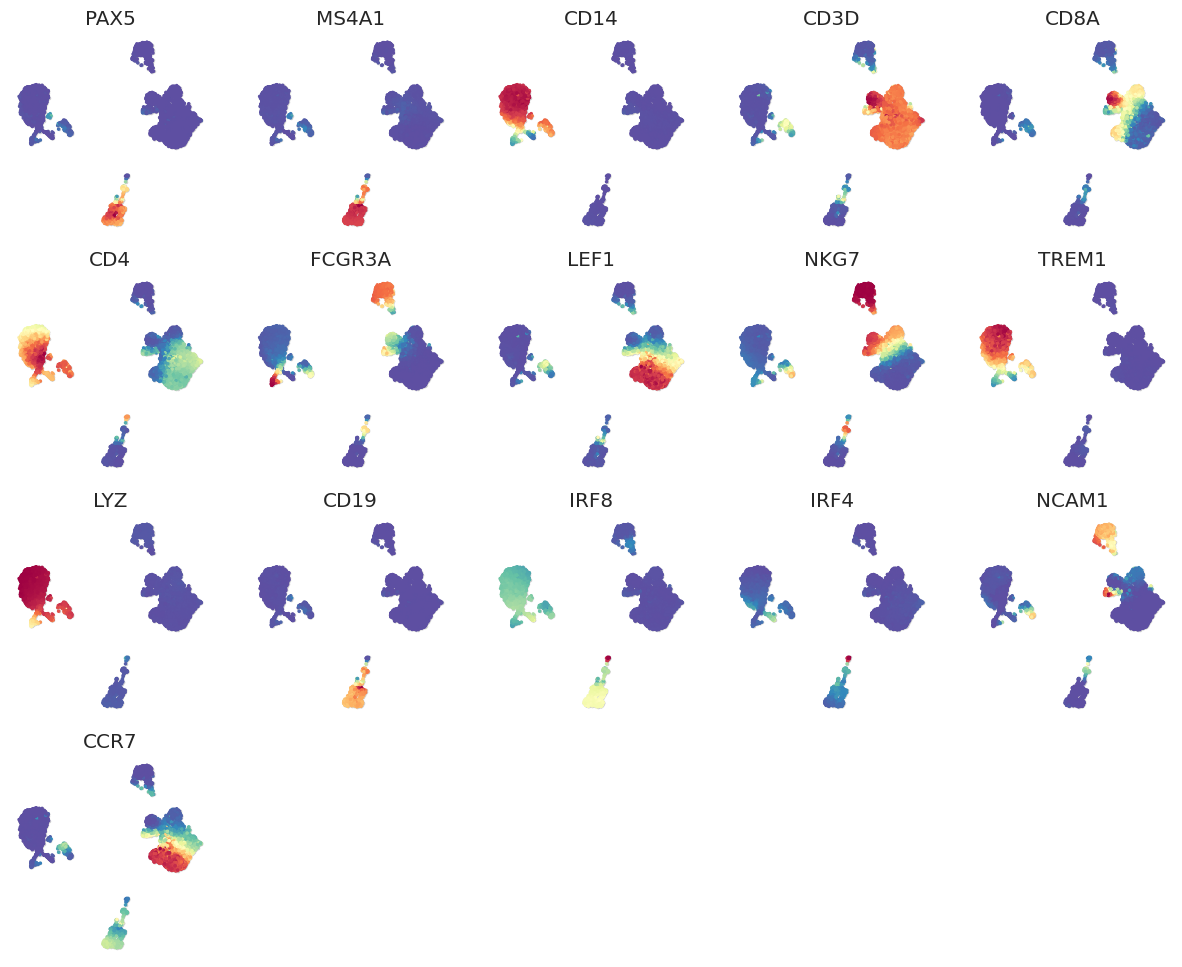

In [47]:
palantir.plot.plot_gene_expression(
    imputed_data,
    pd.DataFrame(ad.obsm["X_umap"], index=ad.obs_names, columns=["x", "y"]),
    marker_genes,
)

We can also plot a subset of these genes, to highlight specific cell populations:

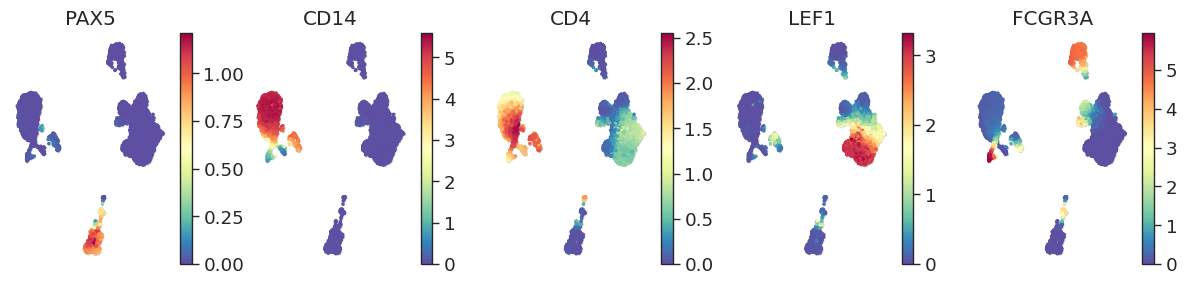

In [48]:
palantir.plot.plot_gene_expression(
    imputed_data,
    pd.DataFrame(ad.obsm["X_umap"], index=ad.obs_names, columns=["x", "y"]),
    ["PAX5", "CD14", "CD4", "LEF1", "FCGR3A"],
    plot_scale=True,
)

Let's compute a B cell signature score, which is the average standardized expression of B cell-specific genes ("PAX5", "MS4A1"). This score can be used to identify B cells in our dataset:

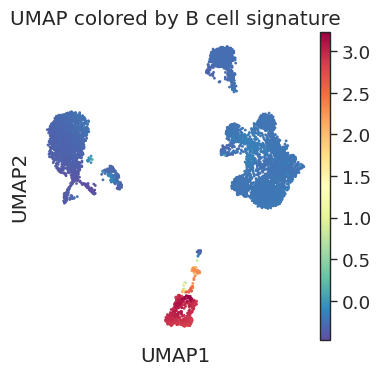

In [49]:
# Define B cell gene signatures
bcell_signature = ["PAX5", "MS4A1"]

# Backup the original .X data
original_X = ad.X.copy()

# Replace .X with the imputed data
ad.X = ad.layers["MAGIC_imputed_data"]

# Calculate the B cell signature score
sc.tl.score_genes(ad, gene_list=bcell_signature, score_name="B_cell_score")

# Restore the original .X data
ad.X = original_X

# Create a scatter plot of the UMAP with color-coded B cell signature
sc.pl.umap(ad, color="B_cell_score", title="UMAP colored by B cell signature")

We can map the cluster labels obtained from Phenograph to known cell types, based on the expression of marker genes:

In [50]:
# Mapping of phenograph values to cell types
phenograph_to_celltype = {
    "0": "CD4 T cells 1",
    "1": "CD4 T cells 2",
    "2": "CD14 Monocytes 1",
    "3": "CD14 Monocytes 2",
    "4": "NK cells 1",
    "5": "CD8 T cells 1",
    "6": "CD8 T cells 2",
    "7": "CD8 T cells 3",
    "8": "pro B cells 1",
    "9": "pro B cells 2",
    "10": "Doublets",
    "11": "NK cells 2",
    "12": "FCGR3A Monocytes",
    "13": "Doublets",
    "14": "Dendritic cells",
    "15": "Doublets",
    "16": "pDC",
}

# Assign cell type to each cell using the mapping
ad.obs["celltype"] = ad.obs["phenograph"].map(phenograph_to_celltype)

Now, let's visualize the identified cell types in the UMAP space:

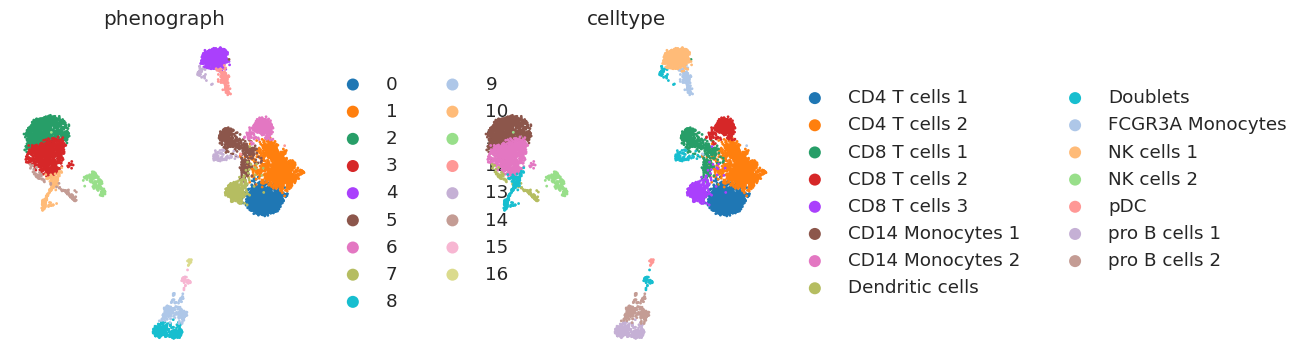

In [51]:
sc.pl.scatter(ad, basis="umap", color=["phenograph", "celltype"], frameon=False)

# Save the Processed Data

Finally, we save the processed AnnData object for future use. It contains the normalized and filtered expression matrix, the computed PCA, UMAP, and Leiden clustering results, as well as the annotated cell types:

In [52]:
ad.write('../data/pbmc_10x_rna_processed.h5ad')

The processed data can be loaded in future sessions using `sc.read_h5ad`.